In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import f1_score
from sklearn.preprocessing import LabelEncoder
from xgboost import XGBClassifier

from ydata_profiling import ProfileReport

import warnings
warnings.filterwarnings("ignore")

C:\Users\Josh\anaconda3\envs\MachineLeaning\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## 0. Funciones

In [23]:
def cat_summary(df):
    """
    Devuelve el resumen de las columnas categóricas con información de nulos.
    
    Parámetros:
    df (pd.DataFrame): El DataFrame original.
    
    Retorna:
    pd.DataFrame: Descripción extendida con nulos.
    """

    cat_cols= df.select_dtypes(include=['object','category']).columns
    desc = df[cat_cols].describe()
    
    nulos_count = df[cat_cols].isnull().sum()
    nulos_porcentaje = 100 * nulos_count / len(df)
    
    desc.loc['nulos_count'] = nulos_count
    desc.loc['nulos_porcentaje'] = nulos_porcentaje.round(2)
    
    return desc
    

def num_summary(df):
    """
    Devuelve el resumen de las columnas numéricas con información de nulos.
    
    Parámetros:
    df (pd.DataFrame): El DataFrame original.
   
    Retorna:
    pd.DataFrame: Descripción extendida con nulos.
    """

    num_cols= df.select_dtypes(exclude=['object','category']).columns
    desc = df[num_cols].describe()
    
    nulos_count = df[num_cols].isnull().sum()
    nulos_porcentaje = 100 * nulos_count / len(df)
    
    desc.loc['nulos_count'] = nulos_count
    desc.loc['nulos_porcentaje'] = nulos_porcentaje.round(2)
    
    return desc

def plot_distributions(df):
    # Filtrar solo columnas numéricas
    df_num = df.select_dtypes(include=['int64', 'float64'])

    num_cols = len(df_num.columns)
    n_cols = 5
    n_rows = int(np.ceil(num_cols / n_cols))

    fig, axs = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(20, n_rows * 3))
    axs = axs.flatten()

    for index, (k, v) in enumerate(df_num.items()):
        sns.histplot(v, bins=20, ax=axs[index])
        axs[index].set_title(k)

    # Elimina los subplots no usados
    for i in range(index + 1, len(axs)):
        fig.delaxes(axs[i])

    plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=5.0)
    plt.show()

## 1. Carga de Datos

In [55]:
train = pd.read_csv('Training_set_values.csv')
labels = pd.read_csv('Training_set_labels.csv')
test = pd.read_csv('Test_set_values.csv')

# Unimos etiquetas al entrenamiento
train = train.merge(labels, on='id')

## 2. Análisis exploratorio

In [20]:
#Para ver mejor las variables y filas
pd.set_option('display.max_columns', 50)
pd.set_option('display.max_rows',50)


train.head()

,id,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,basin,subvillage,region,region_code,district_code,lga,ward,population,public_meeting,recorded_by,scheme_management,scheme_name,permit,construction_year,extraction_type,extraction_type_group,extraction_type_class,management,management_group,payment,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group,status_group
0,69572,6000.0,2011-03-14,Roman,1390,Roman,34.938093,-9.856322,none,0,Lake Nyasa,Mnyusi B,Iringa,11,5,Ludewa,Mundindi,109,True,GeoData Consultants Ltd,VWC,Roman,False,1999,gravity,gravity,gravity,vwc,user-group,pay annually,annually,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe,functional
1,8776,0.0,2013-03-06,Grumeti,1399,GRUMETI,34.698766,-2.147466,Zahanati,0,Lake Victoria,Nyamara,Mara,20,2,Serengeti,Natta,280,NaN,GeoData Consultants Ltd,Other,NaN,True,2010,gravity,gravity,gravity,wug,user-group,never pay,never pay,soft,good,insufficient,insufficient,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe,functional
2,34310,25.0,2013-02-25,Lottery Club,686,World vision,37.460664,-3.821329,Kwa Mahundi,0,Pangani,Majengo,Manyara,21,4,Simanjiro,Ngorika,250,True,GeoData Consultants Ltd,VWC,Nyumba ya mungu pipe scheme,True,2009,gravity,gravity,gravity,vwc,user-group,pay per bucket,per bucket,soft,good,enough,enough,dam,dam,surface,communal standpipe multiple,communal standpipe,functional
3,67743,0.0,2013-01-28,Unicef,263,UNICEF,38.486161,-11.155298,Zahanati Ya Nanyumbu,0,Ruvuma / Southern Coast,Mahakamani,Mtwara,90,63,Nanyumbu,Nanyumbu,58,True,GeoData Consultants Ltd,VWC,NaN,True,1986,submersible,submersible,submersible,vwc,user-group,never pay,never pay,soft,good,dry,dry,machine dbh,borehole,groundwater,communal standpipe multiple,communal standpipe,non functional
4,19728,0.0,2011-07-13,Action In A,0,Artisan,31.130847,-1.825359,Shuleni,0,Lake Victoria,Kyanyamisa,Kagera,18,1,Karagwe,Nyakasimbi,0,True,GeoData Consultants Ltd,NaN,NaN,True,0,gravity,gravity,gravity,other,other,never pay,never pay,soft,good,seasonal,seasonal,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe,functional


In [5]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59400 entries, 0 to 59399
Data columns (total 41 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     59400 non-null  int64  
 1   amount_tsh             59400 non-null  float64
 2   date_recorded          59400 non-null  object 
 3   funder                 55763 non-null  object 
 4   gps_height             59400 non-null  int64  
 5   installer              55745 non-null  object 
 6   longitude              59400 non-null  float64
 7   latitude               59400 non-null  float64
 8   wpt_name               59398 non-null  object 
 9   num_private            59400 non-null  int64  
 10  basin                  59400 non-null  object 
 11  subvillage             59029 non-null  object 
 12  region                 59400 non-null  object 
 13  region_code            59400 non-null  int64  
 14  district_code          59400 non-null  int64  
 15  lg

In [6]:
num_summary(train)

,id,amount_tsh,gps_height,longitude,latitude,num_private,region_code,district_code,population,construction_year
count,59400.000000,59400.000000,59400.000000,59400.000000,5.940000e+04,59400.000000,59400.000000,59400.000000,59400.000000,59400.000000
mean,37115.131768,317.650385,668.297239,34.077427,-5.706033e+00,0.474141,15.297003,5.629747,179.909983,1300.652475
std,21453.128371,2997.574558,693.116350,6.567432,2.946019e+00,12.236230,17.587406,9.633649,471.482176,951.620547
min,0.000000,0.000000,-90.000000,0.000000,-1.164944e+01,0.000000,1.000000,0.000000,0.000000,0.000000
25%,18519.750000,0.000000,0.000000,33.090347,-8.540621e+00,0.000000,5.000000,2.000000,0.000000,0.000000
50%,37061.500000,0.000000,369.000000,34.908743,-5.021597e+00,0.000000,12.000000,3.000000,25.000000,1986.000000
75%,55656.500000,20.000000,1319.250000,37.178387,-3.326156e+00,0.000000,17.000000,5.000000,215.000000,2004.000000
max,74247.000000,350000.000000,2770.000000,40.345193,-2.000000e-08,1776.000000,99.000000,80.000000,30500.000000,2013.000000
nulos_count,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000
nulos_porcentaje,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000


Observamos que no hay nulos en las numéricas. Sin embargo, vemos que hay muchas mediciones en las que la mediana es 0. Esto puede indicar un alto valor de 0 en las variables, lo que puede significar valores perdidos, algo que comprobaremos luego támbien con la funcion Profile Report. Es posible que hayan imputado como 0 los valores numéricos perdidos. Además, la variable gps_height, que mide la altura, tiene valores en negativo, algo que no deberia ocurrir.

In [7]:
cat_summary(train)

,date_recorded,funder,installer,wpt_name,basin,subvillage,region,lga,ward,public_meeting,recorded_by,scheme_management,scheme_name,permit,extraction_type,extraction_type_group,extraction_type_class,management,management_group,payment,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group,status_group
count,59400,55763,55745,59398,59400,59029,59400,59400,59400,56066,59400,55522,30590,56344,59400,59400,59400,59400,59400,59400,59400,59400,59400,59400,59400,59400,59400,59400,59400,59400,59400
unique,356,1896,2145,37399,9,19287,21,125,2092,2,1,11,2695,2,18,13,7,12,5,7,7,8,6,5,5,10,7,3,7,6,3
top,2011-03-15,Government Of Tanzania,DWE,none,Lake Victoria,Madukani,Iringa,Njombe,Igosi,True,GeoData Consultants Ltd,VWC,K,True,gravity,gravity,gravity,vwc,user-group,never pay,never pay,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe,functional
freq,572,9084,17402,3563,10248,508,5294,2503,307,51011,59400,36793,682,38852,26780,26780,26780,40507,52490,25348,25348,50818,50818,33186,33186,17021,17021,45794,28522,34625,32259
nulos_count,0,3637,3655,2,0,371,0,0,0,3334,0,3878,28810,3056,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
nulos_porcentaje,0.0,6.12,6.15,0.0,0.0,0.62,0.0,0.0,0.0,5.61,0.0,6.53,48.5,5.14,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Hay variables como funder, installer, wpt_name, subvillage... que tienen una alta cardinalidad. En las categóricas si que observamos unos porcentajes de perdidos entorno al 6% en algunas variables. Scheme_name además de tener una alta cardinalidad tiene casi un 50% de perdidos, lo que la pone prácticamente fuera de la lista.

In [8]:
train.shape

(59400, 41)

In [9]:
train.dtypes

id                         int64
amount_tsh               float64
date_recorded             object
funder                    object
gps_height                 int64
installer                 object
longitude                float64
latitude                 float64
wpt_name                  object
num_private                int64
basin                     object
subvillage                object
region                    object
region_code                int64
district_code              int64
lga                       object
ward                      object
population                 int64
public_meeting            object
recorded_by               object
scheme_management         object
scheme_name               object
permit                    object
construction_year          int64
extraction_type           object
extraction_type_group     object
extraction_type_class     object
management                object
management_group          object
payment                   object
payment_ty

In [10]:
prof = ProfileReport(train)
prof.to_file(output_file='output.html')

Export report to file: 100%|██████████| 1/1 [00:00<00:00, 35.72it/s]


### CONCLUSIÓN EDA

Tras el análisis exploratorio y el ProfileReport obtenemos las siguientes conjeturas:

- Recorded_by es una constante que no aporta información, solo tiene una constante, será eliminada junto con id. Conservaremos en una primera versión del modelo a Num_private (tiene un 98% de ceros) y scheme_name (tiene altisima cardinalidad y muchos perdidos) pero se estudiará descartarlas. 
- Hay muchas variables numéricas con un alto número de 0 y no tienen a priori nulos. Esto nos hace pensar que esos 0 podrían ser NaN mal imputados. Además, tanto en la longitud como en latitud hay valores muy cercanos a 0 que no coinciden con los valores reales de Tanzania.
- Hay diferentes variables con una alta cardinalidad, habrá que ver cuales elegimos y como tratarlas.
- Hay muchas variables correlacionadas entre si y que en algunos casos aportan casi la misma información. Aunque seguramente usemos herramientas de árboles o booster, intentaremos ver con cuales quedarnos para mejorar la eficiencia del algoritmo.

## 3. Prepocesamiento

### Eliminamos las variables sin sentido.

In [26]:
train.drop(['id', 'recorded_by'], inplace = True, axis = 1)
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59400 entries, 0 to 59399
Data columns (total 39 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   amount_tsh             59400 non-null  float64
 1   date_recorded          59400 non-null  object 
 2   funder                 55763 non-null  object 
 3   gps_height             59400 non-null  int64  
 4   installer              55745 non-null  object 
 5   longitude              59400 non-null  float64
 6   latitude               59400 non-null  float64
 7   wpt_name               59398 non-null  object 
 8   num_private            59400 non-null  int64  
 9   basin                  59400 non-null  object 
 10  subvillage             59029 non-null  object 
 11  region                 59400 non-null  object 
 12  region_code            59400 non-null  int64  
 13  district_code          59400 non-null  int64  
 14  lga                    59400 non-null  object 
 15  wa

### 1. Convertir los 0 de las variables numéricas en nulos.

Como hemos observado es posible que los ceros sean nulos encubiertos. Vamos a probar en esta primera versión a cambiarlos y a ver que tal sale el algoritmo.

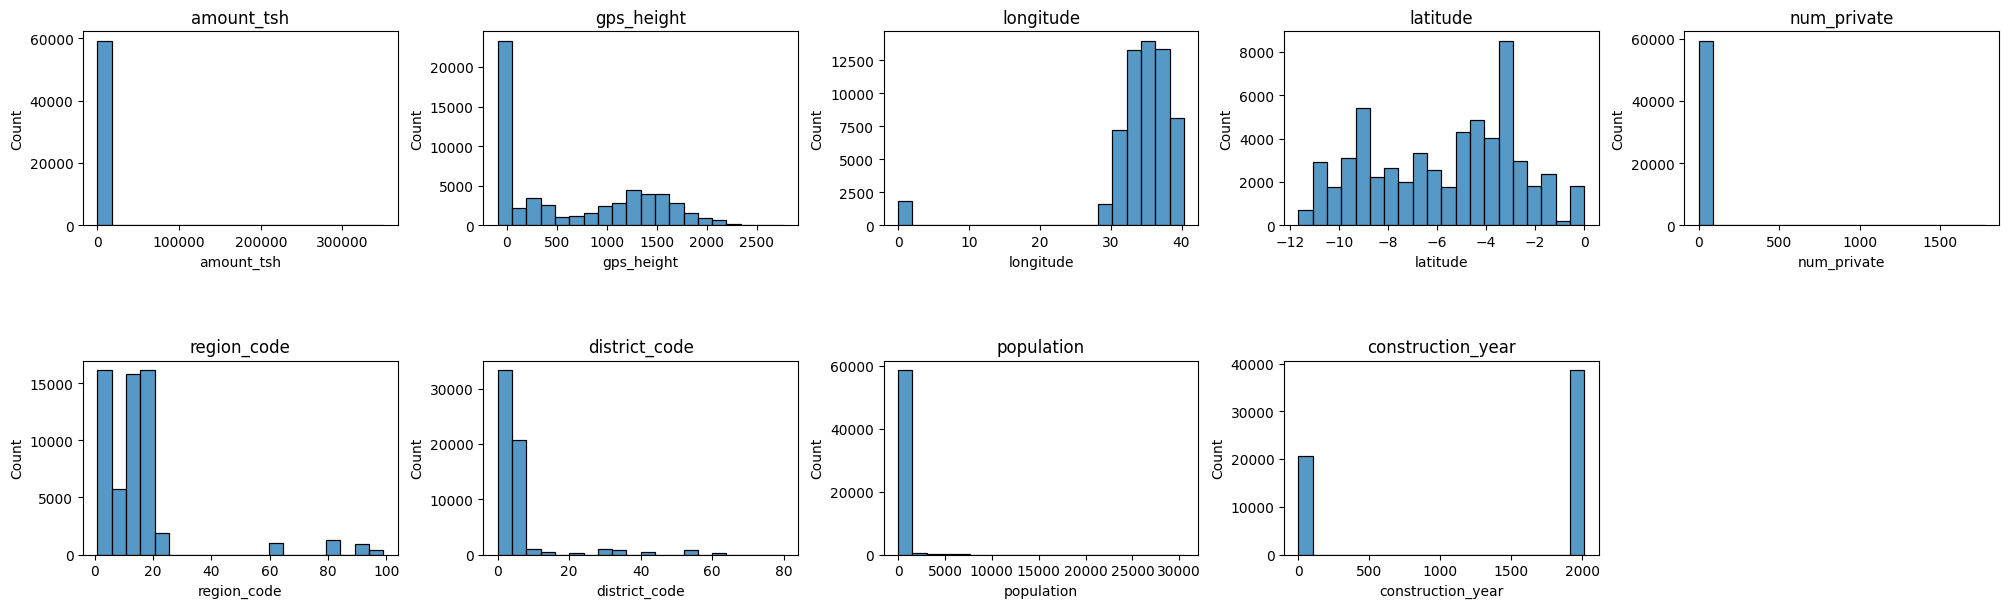

In [27]:
plot_distributions(train)

In [34]:
train['amount_tsh'] = train['amount_tsh'].replace(0, np.nan)
train['construction_year'] = train['construction_year'].replace(0, np.nan)
train['gps_height'] = train['gps_height'].apply(lambda x: np.nan if x <= 0 else x)
train['longitude'] = train['longitude'].replace(0, np.nan)
train['population'] = train['population'].replace(0, np.nan)
train['num_private'] = train['num_private'].replace(0, np.nan)

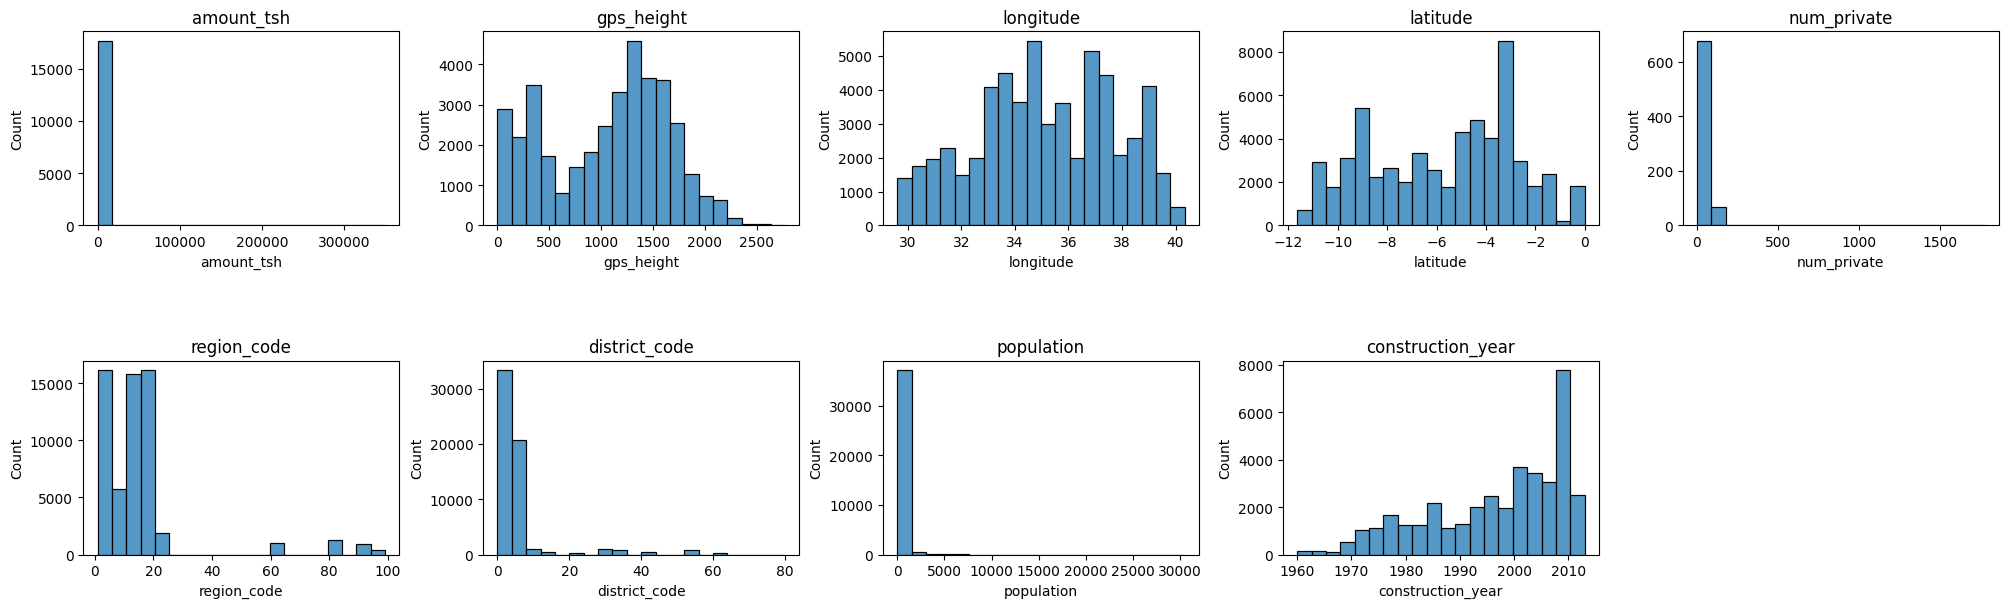

In [35]:
plot_distributions(train)

In [36]:
num_summary(train)

,amount_tsh,gps_height,longitude,latitude,num_private,region_code,district_code,population,construction_year
count,17761.000000,37466.000000,57588.000000,5.940000e+04,757.000000,59400.000000,59400.000000,38019.000000,38691.000000
mean,1062.351942,1060.341803,35.149669,-5.706033e+00,37.204756,15.297003,5.629747,281.087167,1996.814686
std,5409.344940,587.707607,2.607428,2.946019e+00,101.958683,17.587406,9.633649,564.687660,12.472045
min,0.200000,1.000000,29.607122,-1.164944e+01,1.000000,1.000000,0.000000,1.000000,1960.000000
25%,50.000000,471.000000,33.285100,-8.540621e+00,6.000000,5.000000,2.000000,40.000000,1987.000000
50%,250.000000,1194.000000,35.005943,-5.021597e+00,15.000000,12.000000,3.000000,150.000000,2000.000000
75%,1000.000000,1512.000000,37.233712,-3.326156e+00,42.000000,17.000000,5.000000,324.000000,2008.000000
max,350000.000000,2770.000000,40.345193,-2.000000e-08,1776.000000,99.000000,80.000000,30500.000000,2013.000000
nulos_count,41639.000000,21934.000000,1812.000000,0.000000e+00,58643.000000,0.000000,0.000000,21381.000000,20709.000000
nulos_porcentaje,70.100000,36.930000,3.050000,0.000000e+00,98.730000,0.000000,0.000000,35.990000,34.860000


In [37]:
train.isna().sum()

amount_tsh               41639
date_recorded                0
funder                    3637
gps_height               21934
installer                 3655
longitude                 1812
latitude                     0
wpt_name                     2
num_private              58643
basin                        0
subvillage                 371
region                       0
region_code                  0
district_code                0
lga                          0
ward                         0
population               21381
public_meeting            3334
scheme_management         3878
scheme_name              28810
permit                    3056
construction_year        20709
extraction_type              0
extraction_type_group        0
extraction_type_class        0
management                   0
management_group             0
payment                      0
payment_type                 0
water_quality                0
quality_group                0
quantity                     0
quantity

Dejaremos los NaN para un primer testeo del modelo.

In [38]:
X = train.drop(columns='status_group')
y = train['status_group']

In [39]:
from sklearn.preprocessing import OrdinalEncoder

# Seleccionamos columnas categóricas
cat_cols = X.select_dtypes(include=['object', 'category']).columns

# Inicializamos el encoder
encoder = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)

# Aplicamos el encoder solo a las columnas categóricas
X[cat_cols] = encoder.fit_transform(X[cat_cols])

In [40]:
le = LabelEncoder()
y = le.fit_transform(y)

In [43]:
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.metrics import accuracy_score
import xgboost as xgb

In [44]:
model = xgb.XGBClassifier(
    objective='multi:softprob', 
    eval_metric='mlogloss',
    use_label_encoder=False,
    n_estimators=100,
    learning_rate=0.1,
    max_depth=6,
    random_state=42
)

In [45]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

scores = cross_val_score(model, X, y, cv=cv, scoring='accuracy')

print("Accuracy por fold:", scores)
print("Accuracy promedio:", np.mean(scores))

Accuracy por fold: [0.79234007 0.78569024 0.78383838 0.78114478 0.78476431]
Accuracy promedio: 0.7855555555555556


In [46]:
model.fit(X, y)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='mlogloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=6, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=100, n_jobs=None, num_class=3, ...)

In [56]:
ids = test['id'].copy()  # Guardamos los IDs antes de modificar el DataFrame

In [57]:
test['amount_tsh'] = test['amount_tsh'].replace(0, np.nan)
test['construction_year'] = test['construction_year'].replace(0, np.nan)
test['gps_height'] = test['gps_height'].apply(lambda x: np.nan if x <= 0 else x)
test['longitude'] = test['longitude'].replace(0, np.nan)
test['population'] = test['population'].replace(0, np.nan)
test['num_private'] = test['num_private'].replace(0, np.nan)

In [58]:
test.drop(['id', 'recorded_by'], inplace = True, axis = 1)

In [59]:
# Seleccionamos columnas categóricas
cat_cols = test.select_dtypes(include=['object', 'category']).columns

# Inicializamos el encoder
encoder = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)

# Aplicamos el encoder solo a las columnas categóricas
test[cat_cols] = encoder.fit_transform(test[cat_cols])

In [60]:
# Predecir
y_pred_encoded = model.predict(test)
y_pred = le.inverse_transform(y_pred_encoded)  # le = LabelEncoder() usado en y_train

# Generar submission
submission = pd.DataFrame({
    'id': ids, 
    'status_group': y_pred
})
submission.to_csv('submission.csv', index=False)
print("✅ Archivo submission.csv generado correctamente.")

✅ Archivo submission.csv generado correctamente.


Esta primera versión nos da un 0,7708 de score en la competicion.

In [72]:
import shap

# Crear el explainer 
explainer = shap.Explainer(model, X) 
shap_values = explainer(X)

100%|===================| 178156/178200 [23:58<00:00]        

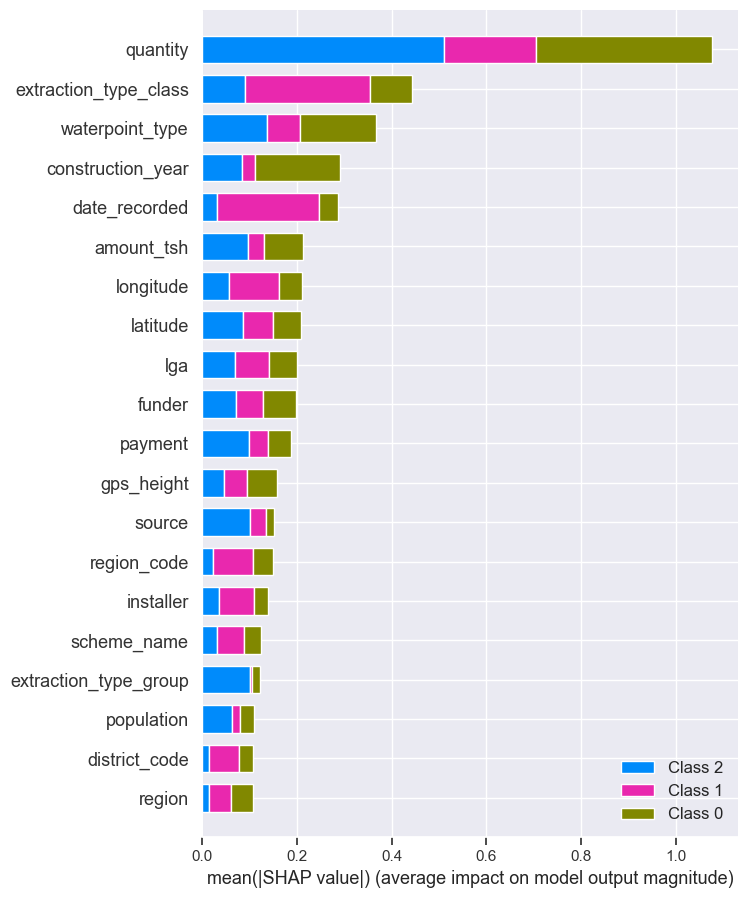

In [73]:
shap.summary_plot(shap_values, X)

# 2A VERSION (BASADO EN LO OBTENIDO HASTA AHORA)

In [148]:
train = pd.read_csv('Training_set_values.csv')
labels = pd.read_csv('Training_set_labels.csv')
test = pd.read_csv('Test_set_values.csv')

# Unimos etiquetas al entrenamiento
train = train.merge(labels, on='id')

In [131]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59400 entries, 0 to 59399
Data columns (total 41 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     59400 non-null  int64  
 1   amount_tsh             59400 non-null  float64
 2   date_recorded          59400 non-null  object 
 3   funder                 55763 non-null  object 
 4   gps_height             59400 non-null  int64  
 5   installer              55745 non-null  object 
 6   longitude              59400 non-null  float64
 7   latitude               59400 non-null  float64
 8   wpt_name               59398 non-null  object 
 9   num_private            59400 non-null  int64  
 10  basin                  59400 non-null  object 
 11  subvillage             59029 non-null  object 
 12  region                 59400 non-null  object 
 13  region_code            59400 non-null  int64  
 14  district_code          59400 non-null  int64  
 15  lg

In [113]:
num_summary(train)

,id,amount_tsh,gps_height,longitude,latitude,num_private,region_code,district_code,population,construction_year
count,59400.000000,59400.000000,59400.000000,59400.000000,5.940000e+04,59400.000000,59400.000000,59400.000000,59400.000000,59400.000000
mean,37115.131768,317.650385,668.297239,34.077427,-5.706033e+00,0.474141,15.297003,5.629747,179.909983,1300.652475
std,21453.128371,2997.574558,693.116350,6.567432,2.946019e+00,12.236230,17.587406,9.633649,471.482176,951.620547
min,0.000000,0.000000,-90.000000,0.000000,-1.164944e+01,0.000000,1.000000,0.000000,0.000000,0.000000
25%,18519.750000,0.000000,0.000000,33.090347,-8.540621e+00,0.000000,5.000000,2.000000,0.000000,0.000000
50%,37061.500000,0.000000,369.000000,34.908743,-5.021597e+00,0.000000,12.000000,3.000000,25.000000,1986.000000
75%,55656.500000,20.000000,1319.250000,37.178387,-3.326156e+00,0.000000,17.000000,5.000000,215.000000,2004.000000
max,74247.000000,350000.000000,2770.000000,40.345193,-2.000000e-08,1776.000000,99.000000,80.000000,30500.000000,2013.000000
nulos_count,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000
nulos_porcentaje,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000


In [114]:
cat_summary(train)

,date_recorded,funder,installer,wpt_name,basin,subvillage,region,lga,ward,public_meeting,recorded_by,scheme_management,scheme_name,permit,extraction_type,extraction_type_group,extraction_type_class,management,management_group,payment,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group,status_group
count,59400,55763,55745,59398,59400,59029,59400,59400,59400,56066,59400,55522,30590,56344,59400,59400,59400,59400,59400,59400,59400,59400,59400,59400,59400,59400,59400,59400,59400,59400,59400
unique,356,1896,2145,37399,9,19287,21,125,2092,2,1,11,2695,2,18,13,7,12,5,7,7,8,6,5,5,10,7,3,7,6,3
top,2011-03-15,Government Of Tanzania,DWE,none,Lake Victoria,Madukani,Iringa,Njombe,Igosi,True,GeoData Consultants Ltd,VWC,K,True,gravity,gravity,gravity,vwc,user-group,never pay,never pay,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe,functional
freq,572,9084,17402,3563,10248,508,5294,2503,307,51011,59400,36793,682,38852,26780,26780,26780,40507,52490,25348,25348,50818,50818,33186,33186,17021,17021,45794,28522,34625,32259
nulos_count,0,3637,3655,2,0,371,0,0,0,3334,0,3878,28810,3056,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
nulos_porcentaje,0.0,6.12,6.15,0.0,0.0,0.62,0.0,0.0,0.0,5.61,0.0,6.53,48.5,5.14,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## 2 Limpieza de datos

Empezamos descartando aquellas con demasiados nulos, variables sin sentido y aquellas que no teniamos claro si descartar, pero que en el anterior análisis eplicatorio de Shap, nos dice que tienen poco peso.

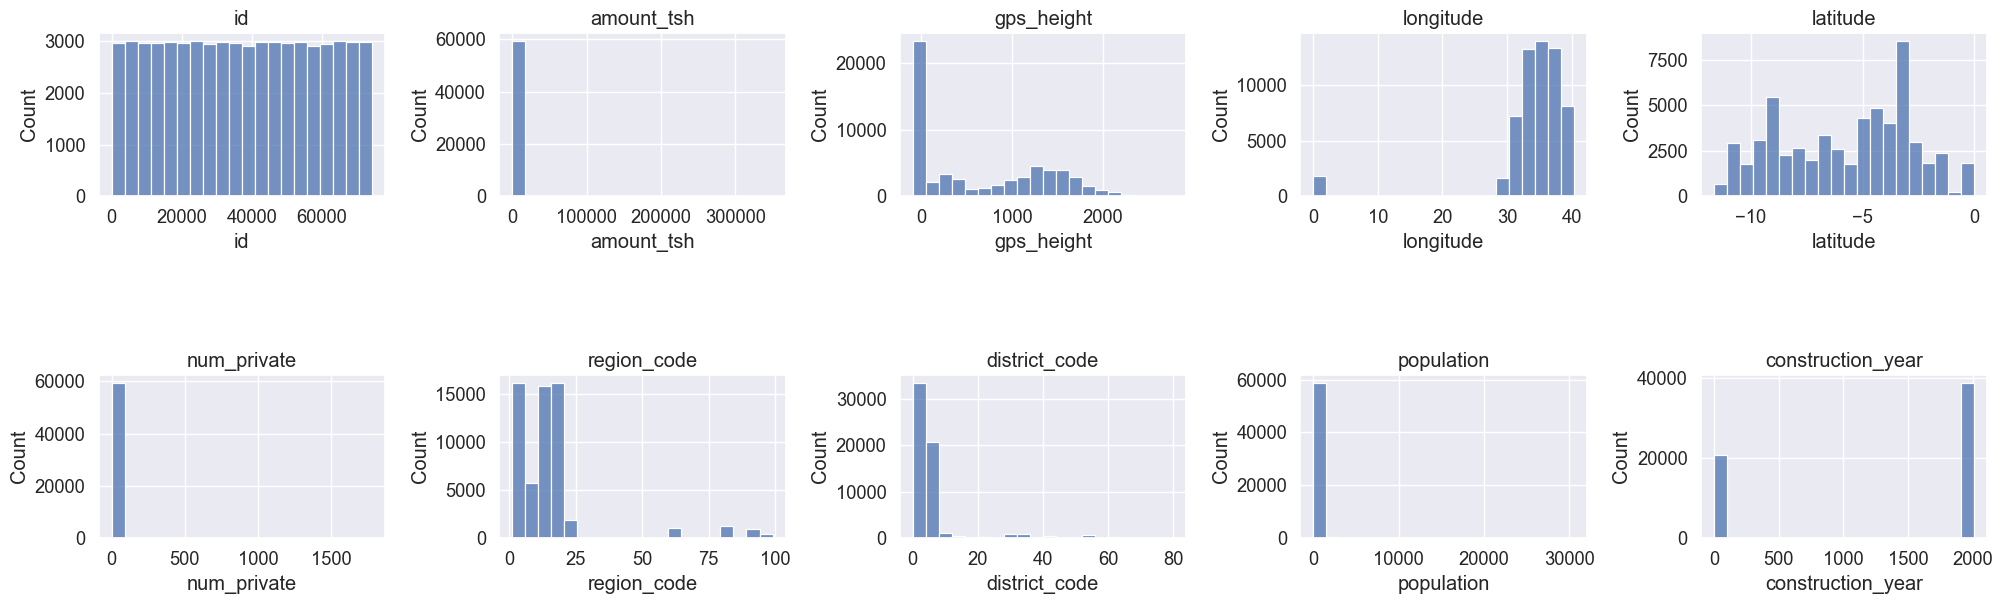

In [115]:
plot_distributions(train)

In [149]:
train.drop(['id','population','scheme_name','num_private','recorded_by'], axis = 1, inplace = True) 
#Dejamos por el momento amount_tsh ya que parece importarle al modelo

In [150]:
#Arreglamos la variable date_recorded
original_dates = train['date_recorded'].copy()
train['date_recorded'] = pd.to_datetime(train['date_recorded'], errors='coerce')

In [151]:
train['year_recorded'] = train['date_recorded'].dt.year
train['month_recorded'] = train['date_recorded'].dt.month
train['day_recorded'] = train['date_recorded'].dt.day

In [152]:
train['date_recorded'] = original_dates

In [153]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59400 entries, 0 to 59399
Data columns (total 39 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   amount_tsh             59400 non-null  float64
 1   date_recorded          59400 non-null  object 
 2   funder                 55763 non-null  object 
 3   gps_height             59400 non-null  int64  
 4   installer              55745 non-null  object 
 5   longitude              59400 non-null  float64
 6   latitude               59400 non-null  float64
 7   wpt_name               59398 non-null  object 
 8   basin                  59400 non-null  object 
 9   subvillage             59029 non-null  object 
 10  region                 59400 non-null  object 
 11  region_code            59400 non-null  int64  
 12  district_code          59400 non-null  int64  
 13  lga                    59400 non-null  object 
 14  ward                   59400 non-null  object 
 15  pu

Vamos a seguir con la hipótesis de que los 0 son en realidad NaN (esta vez vamos a asumirlo en todo el dataset, ya que las categóricas en general no tienen 0 y ya cuentan con sus propios NaN) y vamos intentar imputarlos, al menos en las variables más importantes.

In [154]:
train.replace([0, '0'], np.nan, inplace=True)

In [155]:
def resumen_nulos(df):
    total = df.isna().sum()
    porcentaje = 100 * total / len(df)
    resumen = pd.DataFrame({'nulos': total, 'porcentaje': porcentaje})
    resumen = resumen[resumen['nulos'] > 0].sort_values(by='porcentaje', ascending=False)
    return resumen


resumen_nulos(train)

,nulos,porcentaje
amount_tsh,41639,70.099327
construction_year,20709,34.863636
permit,20548,34.592593
gps_height,20438,34.407407
public_meeting,8389,14.122896
installer,4432,7.461279
funder,4414,7.430976
scheme_management,3878,6.528620
longitude,1812,3.050505
subvillage,371,0.624579


Amount_tsh a pesar de tener un 70% de nulos parece que es una variable importante para el modelo. Por ahora vamos a dejar las que tienen más de un 20% de nulos sin imputar. Incluido evidentemente status_group que es la variable objetivo y no podemos imputarla.

En esta versión vamos a probar a imputar las categóricas por la moda y las numéricas por la media. Tirar el algoritmo y ver que ocurre.

In [156]:
def imputar_nulos(df, inplace=False):
    """
    Imputa:
    - columnas numéricas con la media
    - columnas categóricas con la moda
    Devuelve un nuevo DataFrame si inplace=False.
    """
    if not inplace:
        df = df.copy()

    for col in df.columns:
        if df[col].isna().sum() > 0:
            if df[col].dtype in ['float64', 'int64']:
                media = df[col].mean()
                df[col].fillna(media, inplace=True)
            else:
                moda = df[col].mode(dropna=True)
                if not moda.empty:
                    df[col].fillna(moda[0], inplace=True)

    return df

In [157]:
cols_a_imputar = train.columns.difference(['amount_tsh', 'construction_year', 'gps_height', 'permit', 'status_group'])
train[cols_a_imputar] = imputar_nulos(train[cols_a_imputar])

In [158]:
resumen_nulos(train)

,nulos,porcentaje
amount_tsh,41639,70.099327
construction_year,20709,34.863636
permit,20548,34.592593
gps_height,20438,34.407407


Hacemos el label encoding.

In [159]:
X = train.drop(columns='status_group')
y = train['status_group']

In [160]:
# Seleccionamos columnas categóricas
cat_cols = X.select_dtypes(include=['object', 'category']).columns

# Inicializamos el encoder
encoder = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)

# Aplicamos el encoder solo a las columnas categóricas
X[cat_cols] = encoder.fit_transform(X[cat_cols])

In [161]:
le = LabelEncoder()
y = le.fit_transform(y)

In [163]:
model = xgb.XGBClassifier(
    objective='multi:softprob', 
    eval_metric='mlogloss',
    use_label_encoder=False,
    n_estimators=100,
    learning_rate=0.1,
    max_depth=6,
    random_state=42
)

In [164]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

scores = cross_val_score(model, X, y, cv=cv, scoring='accuracy')

print("Accuracy por fold:", scores)
print("Accuracy promedio:", np.mean(scores))

Accuracy por fold: [0.79023569 0.78510101 0.7797138  0.77676768 0.78299663]
Accuracy promedio: 0.782962962962963


Parece que el accuracy ha bajado. Lo subiremos de todas formas para ver que ocurre.

In [165]:
model.fit(X, y)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='mlogloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=6, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, ...)

In [171]:
ids = test['id'].copy()  # Guardamos los IDs antes de modificar el DataFrame

In [172]:
test.drop(['id','population','scheme_name','num_private','recorded_by'], axis = 1, inplace = True) 

In [173]:
original_dates = test['date_recorded'].copy()
test['date_recorded'] = pd.to_datetime(test['date_recorded'], errors='coerce')

In [174]:
test['year_recorded'] = test['date_recorded'].dt.year
test['month_recorded'] = test['date_recorded'].dt.month
test['day_recorded'] = test['date_recorded'].dt.day

In [175]:
test['date_recorded'] = original_dates

In [176]:
test.replace([0, '0'], np.nan, inplace=True)

In [177]:
cols_a_imputar = test.columns.difference(['amount_tsh', 'construction_year', 'gps_height', 'permit', 'status_group'])
test[cols_a_imputar] = imputar_nulos(test[cols_a_imputar])

In [178]:
# Seleccionamos columnas categóricas
cat_cols = test.select_dtypes(include=['object', 'category']).columns

# Inicializamos el encoder
encoder = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)

# Aplicamos el encoder solo a las columnas categóricas
test[cat_cols] = encoder.fit_transform(test[cat_cols])

In [179]:
# Predecir
y_pred_encoded = model.predict(test)
y_pred = le.inverse_transform(y_pred_encoded)  # le = LabelEncoder() usado en y_train

# Generar submission
submission = pd.DataFrame({
    'id': ids, 
    'status_group': y_pred
})
submission.to_csv('submission2.csv', index=False)
print("✅ Archivo submission.csv generado correctamente.")

✅ Archivo submission.csv generado correctamente.


0.7684 es la nota de está versión. Parece que hemos bajado frente a nuestra versión inicial sin imputar y borrar variables. Al menos podemos confirmar que nuestro test de accuracy local funciona bien! jajajaja

Vamos a tirar el SHAP a ver que nos dice

In [180]:
explainer = shap.Explainer(model, X)  
shap_values = explainer(X)

100%|===================| 178144/178200 [22:59<00:00]        

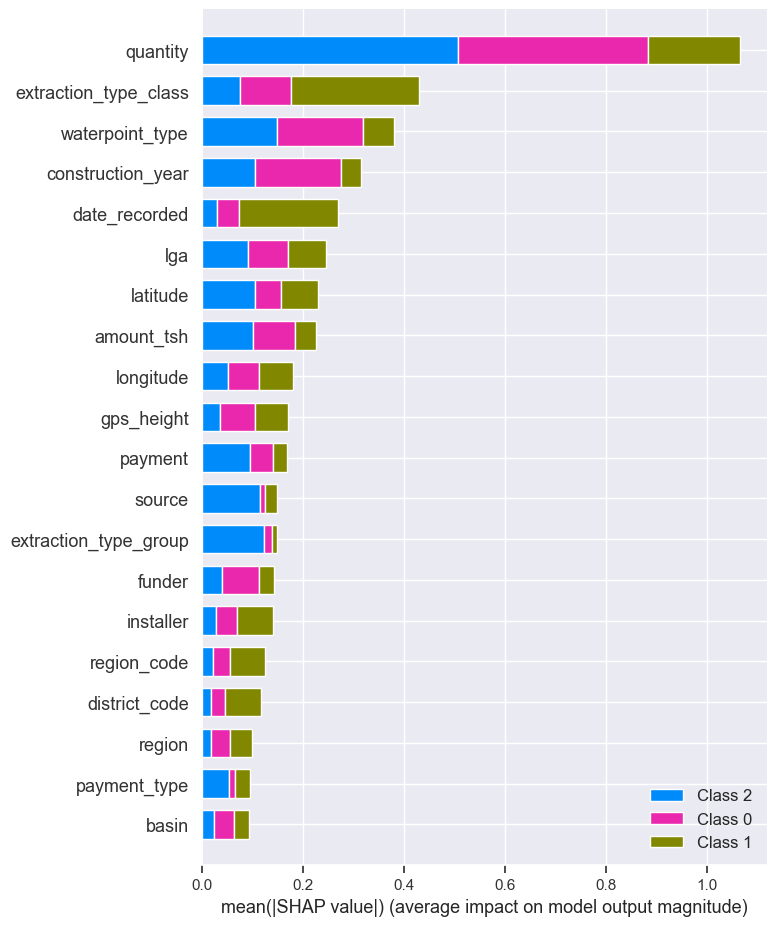

In [181]:
shap.summary_plot(shap_values, X)

# Versión 3 (BASANDONOS EN EL TEST DE SHAP DE LA PRIMERA VERSIÓN)

Según el test de Shap las variables por encima del valor 0 aportan información al modelo, pero el resto no. Asique lo que vamos a hacer será eliminar todas aquellas variables que no aparezcan en la primer gráfico de SHAP. Pero con el mismo proceso que en el ejercicio anterior.

In [213]:
train = pd.read_csv('Training_set_values.csv')
labels = pd.read_csv('Training_set_labels.csv')
test = pd.read_csv('Test_set_values.csv')

# Unimos etiquetas al entrenamiento
train = train.merge(labels, on='id')

In [214]:
# Lista de variables importantes del gráfico SHAP
vars_shap = [
    'quantity', 'extraction_type_class', 'waterpoint_type', 'construction_year',
    'date_recorded', 'amount_tsh', 'longitude', 'latitude', 'lga', 'funder',
    'payment', 'gps_height', 'source', 'region_code', 'installer', 'scheme_name',
    'extraction_type_group', 'population', 'district_code', 'region', 'status_group'
]

# Eliminar columnas que no están en vars_shap
train = train.drop(columns=train.columns.difference(vars_shap))

In [215]:
train

,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,region,region_code,district_code,lga,population,scheme_name,construction_year,extraction_type_group,extraction_type_class,payment,quantity,source,waterpoint_type,status_group
0,6000.0,2011-03-14,Roman,1390,Roman,34.938093,-9.856322,Iringa,11,5,Ludewa,109,Roman,1999,gravity,gravity,pay annually,enough,spring,communal standpipe,functional
1,0.0,2013-03-06,Grumeti,1399,GRUMETI,34.698766,-2.147466,Mara,20,2,Serengeti,280,NaN,2010,gravity,gravity,never pay,insufficient,rainwater harvesting,communal standpipe,functional
2,25.0,2013-02-25,Lottery Club,686,World vision,37.460664,-3.821329,Manyara,21,4,Simanjiro,250,Nyumba ya mungu pipe scheme,2009,gravity,gravity,pay per bucket,enough,dam,communal standpipe multiple,functional
3,0.0,2013-01-28,Unicef,263,UNICEF,38.486161,-11.155298,Mtwara,90,63,Nanyumbu,58,NaN,1986,submersible,submersible,never pay,dry,machine dbh,communal standpipe multiple,non functional
4,0.0,2011-07-13,Action In A,0,Artisan,31.130847,-1.825359,Kagera,18,1,Karagwe,0,NaN,0,gravity,gravity,never pay,seasonal,rainwater harvesting,communal standpipe,functional
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59395,10.0,2013-05-03,Germany Republi,1210,CES,37.169807,-3.253847,Kilimanjaro,3,5,Hai,125,Losaa Kia water supply,1999,gravity,gravity,pay per bucket,enough,spring,communal standpipe,functional
59396,4700.0,2011-05-07,Cefa-njombe,1212,Cefa,35.249991,-9.070629,Iringa,11,4,Njombe,56,Ikondo electrical water sch,1996,gravity,gravity,pay annually,enough,river,communal standpipe,functional
59397,0.0,2011-04-11,NaN,0,NaN,34.017087,-8.750434,Mbeya,12,7,Mbarali,0,NaN,0,swn 80,handpump,pay monthly,enough,machine dbh,hand pump,functional
59398,0.0,2011-03-08,Malec,0,Musa,35.861315,-6.378573,Dodoma,1,4,Chamwino,0,NaN,0,nira/tanira,handpump,never pay,insufficient,shallow well,hand pump,functional


In [216]:
#Arreglamos la variable date_recorded
original_dates = train['date_recorded'].copy()
train['date_recorded'] = pd.to_datetime(train['date_recorded'], errors='coerce')

In [217]:
train['year_recorded'] = train['date_recorded'].dt.year
train['month_recorded'] = train['date_recorded'].dt.month
train['day_recorded'] = train['date_recorded'].dt.day

In [218]:
train['date_recorded'] = original_dates

In [219]:
train.replace([0, '0'], np.nan, inplace=True)

In [220]:
resumen_nulos(train)

,nulos,porcentaje
amount_tsh,41639,70.099327
scheme_name,28810,48.501684
population,21381,35.994949
construction_year,20709,34.863636
gps_height,20438,34.407407
installer,4432,7.461279
funder,4414,7.430976
longitude,1812,3.050505
district_code,23,0.038721


Vamos a imputar solo las 4 últimas. El resto tienen demasiados nulos como para imputar por media y moda.

In [221]:
cols_a_imputar = ['installer', 'funder', 'longitude', 'district_code']
train[cols_a_imputar] = imputar_nulos(train[cols_a_imputar])

In [222]:
resumen_nulos(train)

,nulos,porcentaje
amount_tsh,41639,70.099327
scheme_name,28810,48.501684
population,21381,35.994949
construction_year,20709,34.863636
gps_height,20438,34.407407


In [223]:
X = train.drop(columns='status_group')
y = train['status_group']

In [224]:
# Seleccionamos columnas categóricas
cat_cols = X.select_dtypes(include=['object', 'category']).columns

# Inicializamos el encoder
encoder = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)

# Aplicamos el encoder solo a las columnas categóricas
X[cat_cols] = encoder.fit_transform(X[cat_cols])

In [225]:
le = LabelEncoder()
y = le.fit_transform(y)

# Prueba de modelos

In [226]:
model = xgb.XGBClassifier(
    objective='multi:softprob', 
    eval_metric='mlogloss',
    use_label_encoder=False,
    n_estimators=100,
    learning_rate=0.1,
    max_depth=6,
    random_state=42
)


In [227]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

scores = cross_val_score(model, X, y, cv=cv, scoring='accuracy')

print("Accuracy por fold:", scores)
print("Accuracy promedio:", np.mean(scores))

Accuracy por fold: [0.79107744 0.78670034 0.77954545 0.77643098 0.78122896]
Accuracy promedio: 0.782996632996633


Vamos a probar con un RandomForest

In [228]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(
    n_estimators=100,
    max_depth=6,
    random_state=42,
    n_jobs=-1  # Usa todos los núcleos disponibles (opcional, pero recomendable)
)

In [229]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

scores = cross_val_score(model, X, y, cv=cv, scoring='accuracy')

print("Accuracy por fold:", scores)
print("Accuracy promedio:", np.mean(scores))

Accuracy por fold: [0.73695286 0.73265993 0.72878788 0.7266835  0.73055556]
Accuracy promedio: 0.7311279461279462


Claramente peor. Vamos a probar otros tipos de modelos.

In [231]:
from lightgbm import LGBMClassifier

model = LGBMClassifier(
    objective='multiclass',
    num_class=3,  # Cambia según tu número de clases
    n_estimators=100,
    learning_rate=0.1,
    max_depth=6,
    random_state=42
)

In [232]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

scores = cross_val_score(model, X, y, cv=cv, scoring='accuracy')

print("Accuracy por fold:", scores)
print("Accuracy promedio:", np.mean(scores))

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000460 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2413
[LightGBM] [Info] Number of data points in the train set: 47520, number of used features: 23
[LightGBM] [Info] Start training from score -0.610505
[LightGBM] [Info] Start training from score -2.621618
[LightGBM] [Info] Start training from score -0.956493
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further spl

Este lo mejora. Bien!

In [234]:
from catboost import CatBoostClassifier

model = CatBoostClassifier(
    loss_function='MultiClass',
    iterations=100,
    learning_rate=0.1,
    depth=6,
    random_seed=42,
    verbose=0
)

In [235]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

scores = cross_val_score(model, X, y, cv=cv, scoring='accuracy')

print("Accuracy por fold:", scores)
print("Accuracy promedio:", np.mean(scores))

Accuracy por fold: [0.76548822 0.75959596 0.75547138 0.75277778 0.75639731]
Accuracy promedio: 0.7579461279461279


Parece que LightGbm es el mejor por ahora.

In [237]:
model = LGBMClassifier(
    objective='multiclass',
    num_class=3,  # Cambia según tu número de clases
    n_estimators=100,
    learning_rate=0.1,
    max_depth=6,
    random_state=42
)

In [238]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

scores = cross_val_score(model, X, y, cv=cv, scoring='accuracy')

print("Accuracy por fold:", scores)
print("Accuracy promedio:", np.mean(scores))

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002322 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2413
[LightGBM] [Info] Number of data points in the train set: 47520, number of used features: 23
[LightGBM] [Info] Start training from score -0.610505
[LightGBM] [Info] Start training from score -2.621618
[LightGBM] [Info] Start training from score -0.956493
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No 

# Vamos a mejorarlo con el GridSearch

In [241]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint, uniform

param_dist = {
    'n_estimators': randint(50, 200),
    'learning_rate': uniform(0.01, 0.2),
    'max_depth': randint(3, 8),
    'num_leaves': randint(20, 80),
    'min_child_samples': randint(10, 50),
    'subsample': uniform(0.8, 0.2),
    'colsample_bytree': uniform(0.8, 0.2)
}

model = LGBMClassifier(objective='multiclass', num_class=3, random_state=42)

random_search = RandomizedSearchCV(
    model, param_distributions=param_dist,
    n_iter=30,  # Podés probar 30 combinaciones en lugar de 648
    scoring='accuracy', cv=3, n_jobs=-1, random_state=42, verbose=1
)

random_search.fit(X, y)
print("Mejores parámetros:", random_search.best_params_)

Fitting 3 folds for each of 30 candidates, totalling 90 fits
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003111 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2425
[LightGBM] [Info] Number of data points in the train set: 59400, number of used features: 23
[LightGBM] [Info] Start training from score -0.610497
[LightGBM] [Info] Start training from score -2.621734
[LightGBM] [Info] Start training from score -0.956482
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits

In [242]:
final_model = LGBMClassifier(
    objective='multiclass',
    num_class=3,
    colsample_bytree=0.8628711962152654,
    learning_rate=0.11171413823294056,
    max_depth=7,
    min_child_samples=32,
    n_estimators=192,
    num_leaves=62,
    subsample=0.840612244946954,
    random_state=42
)


In [243]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

scores = cross_val_score(model, X, y, cv=cv, scoring='accuracy')

print("Accuracy por fold:", scores)
print("Accuracy promedio:", np.mean(scores))

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002678 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2413
[LightGBM] [Info] Number of data points in the train set: 47520, number of used features: 23
[LightGBM] [Info] Start training from score -0.610505
[LightGBM] [Info] Start training from score -2.621618
[LightGBM] [Info] Start training from score -0.956493
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002383 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2421
[LightGBM] [Info] Number of data points in the train set: 47520, number of used features: 23
[LightGBM] [Info] Start training from score -0.610505
[LightGBM] [Info] Start training from score -2.621618
[LightGBM] [Info] Start training from score -0.956493
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000524 sec

Bien! Ha mejorado! Utilizaremos este para subir una prueba!

# Ultima Prueba!

In [244]:
model.fit(X, y)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002774 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2425
[LightGBM] [Info] Number of data points in the train set: 59400, number of used features: 23
[LightGBM] [Info] Start training from score -0.610497
[LightGBM] [Info] Start training from score -2.621734
[LightGBM] [Info] Start training from score -0.956482


LGBMClassifier(num_class=3, objective='multiclass', random_state=42)

In [245]:
ids = test['id'].copy() 

In [247]:
# Lista de variables importantes del gráfico SHAP
vars_shap = [
    'quantity', 'extraction_type_class', 'waterpoint_type', 'construction_year',
    'date_recorded', 'amount_tsh', 'longitude', 'latitude', 'lga', 'funder',
    'payment', 'gps_height', 'source', 'region_code', 'installer', 'scheme_name',
    'extraction_type_group', 'population', 'district_code', 'region', 'status_group'
]

# Eliminar columnas que no están en vars_shap
test = test.drop(columns=test.columns.difference(vars_shap))

In [248]:
#Arreglamos la variable date_recorded
original_dates = test['date_recorded'].copy()
test['date_recorded'] = pd.to_datetime(test['date_recorded'], errors='coerce')

In [249]:
test['year_recorded'] = test['date_recorded'].dt.year
test['month_recorded'] = test['date_recorded'].dt.month
test['day_recorded'] = test['date_recorded'].dt.day

In [250]:
test['date_recorded'] = original_dates

In [251]:
test.replace([0, '0'], np.nan, inplace=True)

In [252]:
cols_a_imputar = ['installer', 'funder', 'longitude', 'district_code']
test[cols_a_imputar] = imputar_nulos(test[cols_a_imputar])

In [253]:
# Seleccionamos columnas categóricas
cat_cols = test.select_dtypes(include=['object', 'category']).columns

# Inicializamos el encoder
encoder = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)

# Aplicamos el encoder solo a las columnas categóricas
test[cat_cols] = encoder.fit_transform(test[cat_cols])

In [254]:
# Predecir
y_pred_encoded = model.predict(test)
y_pred = le.inverse_transform(y_pred_encoded)  # le = LabelEncoder() usado en y_train

# Generar submission
submission = pd.DataFrame({
    'id': ids, 
    'status_group': y_pred
})
submission.to_csv('submission3.csv', index=False)
print("✅ Archivo submission.csv generado correctamente.")

✅ Archivo submission.csv generado correctamente.


Esta versión nos da un 0.7749. Hemos mejorado en un 0,41% la anterior mejor versión .